# Chocolate Revenue Analysis(ARIMA, SARIMA, SARIMAX)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# use pmdarima for automatic ARIMA order selection, currently not working with python 3.13

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate(train, test, pred, title):
    y_true = test
    y_pred = pred
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print("{} Errors: rmse = {}, mae = {}, mape = {}".format(title, rmse, mae, mape))

    plt.figure(figsize=(15, 7))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(pred, label=title)
    plt.legend()
    plt.show()

## Take a peek at data

              revenue  discount_rate  coupon_rate
date                                             
2018-01-01  6270839.0         0.3427       0.0109
2018-01-02  8922076.0         0.3087       0.0108
2018-01-03  8446101.0         0.2811       0.0101
2018-01-04  7785798.0         0.2732       0.0096
2018-01-05  6375303.0         0.2570       0.0090


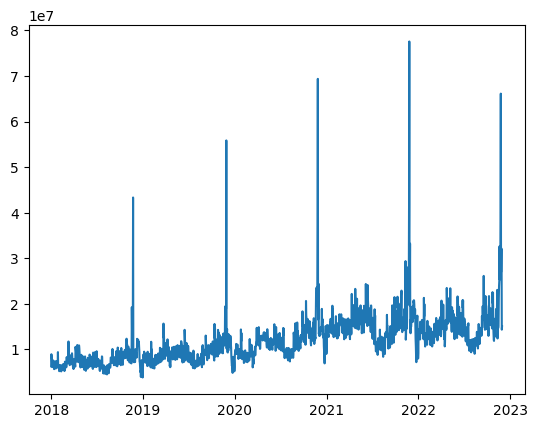

In [3]:
# Load
df = pd.read_csv('./data/daily_revenue.csv', index_col='date', parse_dates=True, dayfirst=True)
df = df.asfreq('D')
df['revenue'] = df['revenue'].str.replace(',', '').astype(float)
df['coupon_rate'] = df['coupon_rate'].str.replace('%', '').astype(float).multiply(0.01)
df['discount_rate'] = df['discount_rate'].str.replace('%', '').astype(float).multiply(0.01)
print(df.head())
plt.plot(df['revenue'])
plt.show()

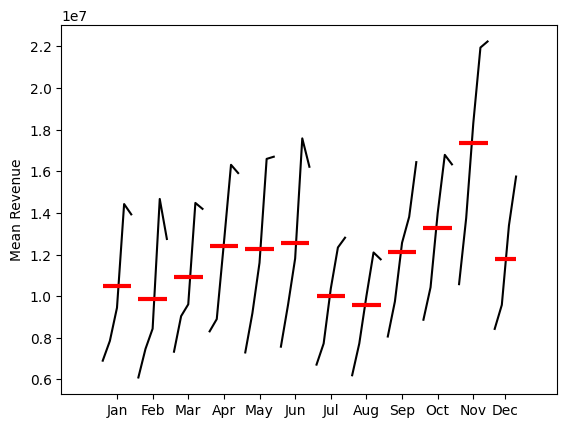

In [4]:

month_plot(df['revenue'].resample('ME').mean(), ylabel='Mean Revenue')
plt.show()

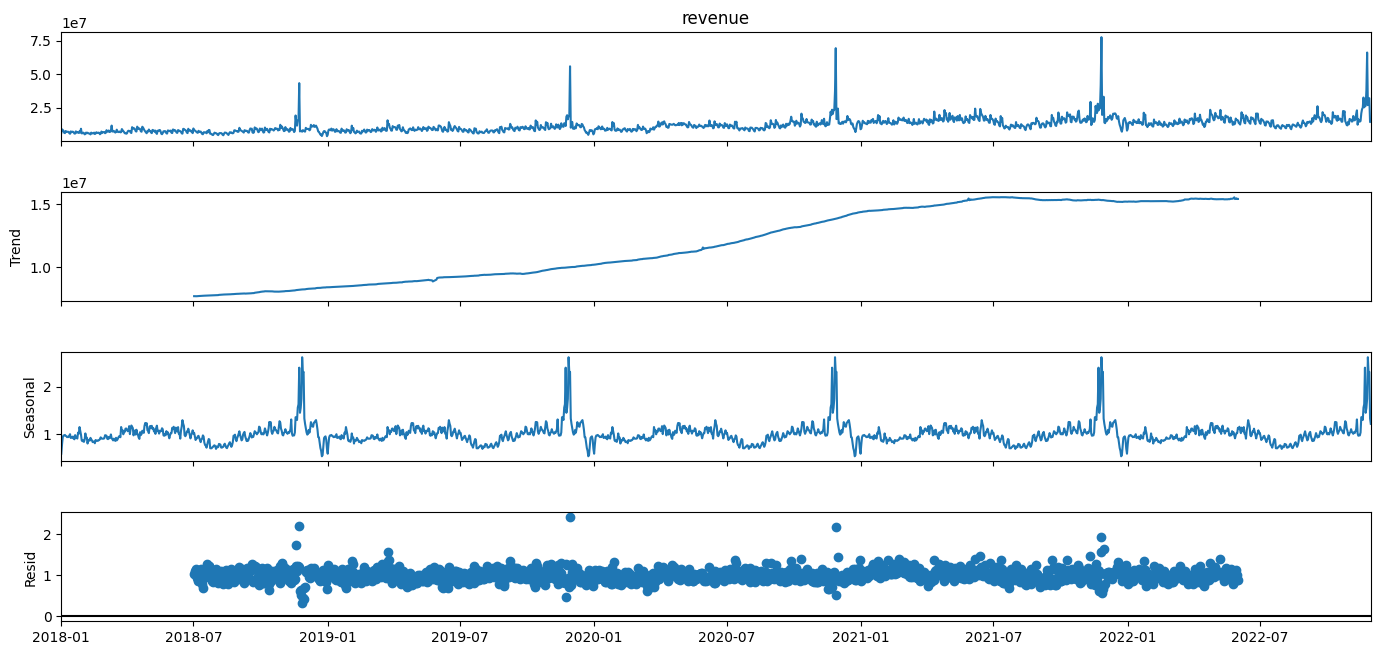

In [5]:
decompositionMul = seasonal_decompose(df['revenue'], model='multiplicative', period=365)
fig = decompositionMul.plot()
fig.set_size_inches(15, 7)
plt.show()

## ARIMA
- AR(Auto-Regression): captures past data's impack on current value.
  - param `p`: the number of lagged observations
- I(Integrated): differencing data to smoothout non-stationary data to more stationary data. (Stationarity means that the statistical properties of the series (like mean and variance) do not change over time.)
  - param `d`: the number of times needed to difference the data to achieve stationary
- MA(Moving Average): captures past errors' impact on current value.
  - param `q`: the size of moving average window.

In [6]:
# check if it is stationary
stationary = adfuller(df['revenue'])
print(stationary)
pValue = stationary[1]
print('p value: ', pValue)
if pValue > 0.05:
    print('Not stationary')
else:
    print('Stationary')

(np.float64(-2.5583995323513906), np.float64(0.10190360862386172), 21, 1773, {'1%': np.float64(-3.4340436225819664), '5%': np.float64(-2.8631715289228103), '10%': np.float64(-2.567638575476797)}, np.float64(57965.93222671933))
p value:  0.10190360862386172
Not stationary


(np.float64(-12.808786916715945), np.float64(6.5137920268179835e-24), 20, 1773, {'1%': np.float64(-3.4340436225819664), '5%': np.float64(-2.8631715289228103), '10%': np.float64(-2.567638575476797)}, np.float64(57938.80449422392))
p value:  6.5137920268179835e-24
Stationary


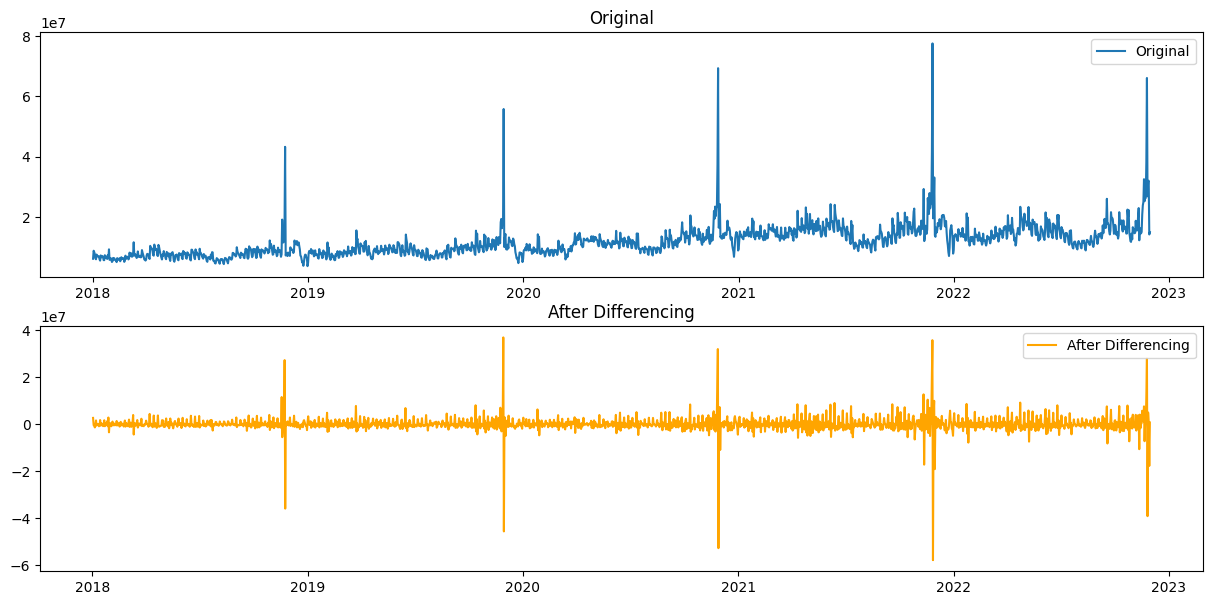

In [7]:
# differencing data to make it stationary
df['revenue_diff'] = df['revenue'].diff()

stationary = adfuller(df['revenue_diff'].dropna())
print(stationary)
pValue = stationary[1]
print('p value: ', pValue)
if pValue > 0.05:
    print('Not stationary')
else:
    print('Stationary')

plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(df['revenue'], label='Original')
plt.title('Original')
plt.legend()
plt.subplot(212)
plt.title('After Differencing')
plt.plot(df['revenue_diff'], label='After Differencing', color='orange')
plt.legend()
plt.show()


In [8]:
# Splitting data
periods = 30
train = df[:-periods]
test = df[-periods:]
train_revenue = train['revenue']
test_revenue = test['revenue']
exog_train = train[['coupon_rate', 'discount_rate']]
exog_test = test[['coupon_rate', 'discount_rate']]

In [9]:
# create ARIMA model and select best parameters

import warnings
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to ")

# Define the range of parameters to search
p_values = range(0, 5)  # AR terms
d_values = [1] # range(0, 3)  # Differencing terms
q_values = range(0, 5)  # MA terms

# Function to evaluate ARIMA model
def evaluate_arima_model(train, p, d, q):
    try:
        model = ARIMA(train_revenue, order=(p, d, q))
        model_fit = model.fit()
        return model_fit.aic, model_fit.bic  # Return both AIC and BIC
    except:
        return np.inf, np.inf  # Return large values if the model fails

# Perform grid search
best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            aic, bic = evaluate_arima_model(train, p, d, q)
            # Combine AIC and BIC into a single score (e.g., weighted sum or prioritize AIC)
            combined_score = aic + bic 
            if combined_score < best_score:
                best_score, best_cfg = combined_score, (p, d, q)

print(f"Best ARIMA parameters: {best_cfg} with AIC={best_score}")

# Fit the best ARIMA model
best_p, best_d, best_q = best_cfg
model = ARIMA(train_revenue, order=(best_p, best_d, best_q))
model_fit = model.fit()
print(model_fit.summary())

Best ARIMA parameters: (3, 1, 4) with AIC=115313.75813559938
                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                 1765
Model:                 ARIMA(3, 1, 4)   Log Likelihood              -28809.489
Date:                Wed, 26 Mar 2025   AIC                          57634.978
Time:                        20:54:52   BIC                          57678.780
Sample:                    01-01-2018   HQIC                         57651.163
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5368      0.040     13.409      0.000       0.458       0.615
ar.L2         -0.1255      0.050     -2.517      0.012      -0.223    

ARIMA Errors: rmse = 13372119.794047078, mae = 8182978.394424034, mape = 0.2759807705443991


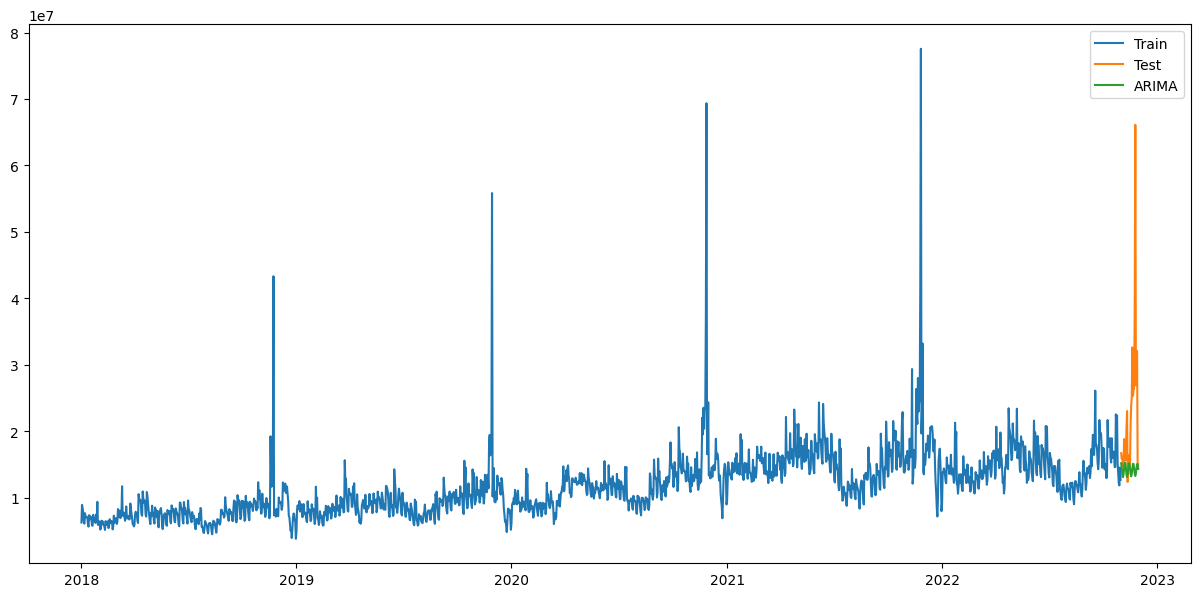

In [10]:
arima_pred = model_fit.forecast(steps=periods)

evaluate(train_revenue, test_revenue, arima_pred,  'ARIMA')

## SARIMA
Adds seasonal effect to ARIMA.

In [11]:
# SARIMA


# Define the range of parameters to search
p_values = [3]# range(0, 5)  # AR terms
d_values = [1] # range(0, 3)  # Differencing terms
q_values = [2]# range(0, 5)  # MA terms
P_values = [2]# range(0, 3)  # Seasonal AR terms
D_values = [0]  # Seasonal differencing terms
Q_values = [2]# range(0, 3)  # Seasonal MA terms
s = 7 # 365  # Seasonal period(for daily data, 7 is recommended)

# find best parameters
best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:

                        model = SARIMAX(train_revenue, order=(p, d, q), seasonal_order=(P, D, Q, s))
                        model_fit = model.fit(disp=False)
                        aic, bic = model_fit.aic, model_fit.bic
                        combined_score = aic + bic
                        if combined_score < best_score:
                            best_score, best_cfg = combined_score, (p, d, q, P, D, Q)

print(f"Best SARIMA parameters: {best_cfg} with Score={best_score}")

# Fit the best SARIMA model
best_p, best_d, best_q, best_P, best_D, best_Q = best_cfg
model = SARIMAX(train_revenue, order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, s))
model_fit = model.fit()
print(model_fit.summary())

Best SARIMA parameters: (3, 1, 2, 2, 0, 2) with Score=115011.80062867323
                                     SARIMAX Results                                     
Dep. Variable:                           revenue   No. Observations:                 1765
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28729.262
Date:                           Wed, 26 Mar 2025   AIC                          57478.524
Time:                                   20:54:58   BIC                          57533.277
Sample:                               01-01-2018   HQIC                         57498.756
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1327      0.116      1.143      

SARIMA Errors: rmse = 12490678.093487442, mae = 7404574.983864754, mape = 0.24874618017432581


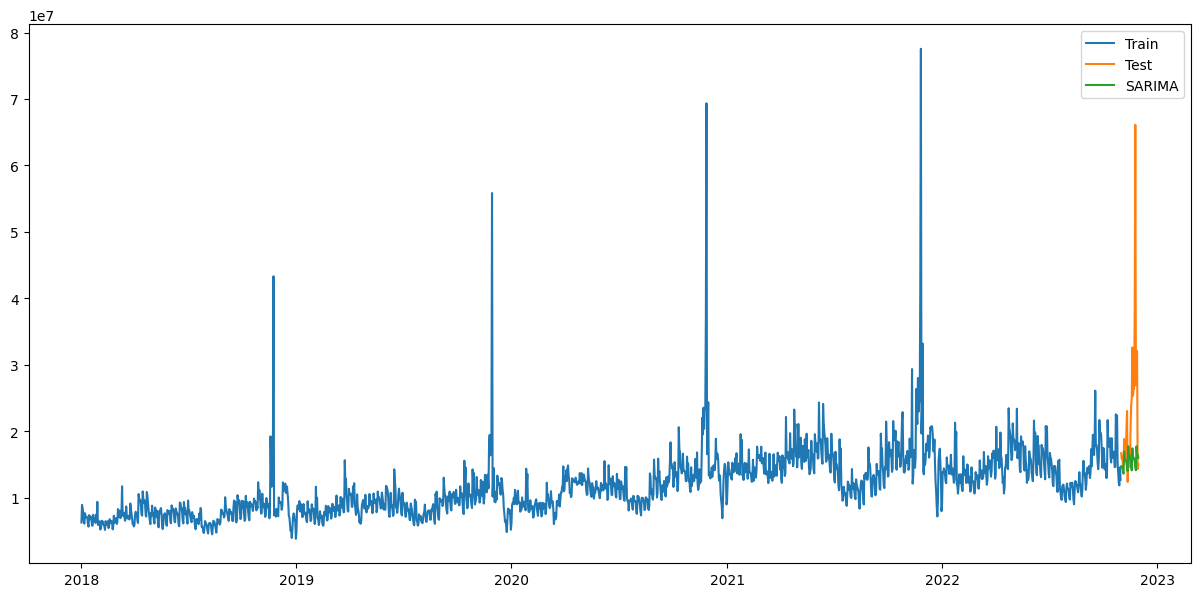

In [12]:
sarima_pred = model_fit.forecast(steps=periods)

evaluate(train_revenue, test_revenue, sarima_pred,  'SARIMA')

## SARIMAX
Adds exogenous variables to consideration.

In [13]:
# SARIMAX

# Define the range of parameters to search
p_values = [2]# range(0, 5)  # AR terms
d_values = [1] # range(0, 3)  # Differencing terms
q_values = [2]# range(0, 5)  # MA terms
P_values = [2]# range(0, 3)  # Seasonal AR terms
D_values = [0]  # Seasonal differencing terms
Q_values = [2]# range(0, 3)  # Seasonal MA terms
s = 7 # 365  # Seasonal period(for daily data, 7 is recommended)



# find best parameters
best_score, best_cfg = float("inf"), None



for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        model = SARIMAX(train_revenue, order=(p, d, q), seasonal_order=(P, D, Q, s), exog=exog_train)
                        model_fit = model.fit(disp=False)
                        aic, bic = model_fit.aic, model_fit.bic
                        combined_score = aic + bic
                        if combined_score < best_score:
                            best_score, best_cfg = combined_score, (p, d, q, P, D, Q)

print(f"Best SARIMAX parameters: {best_cfg} with Score={best_score}")

# Fit the best SARIMAX model
best_p, best_d, best_q, best_P, best_D, best_Q = best_cfg
model = SARIMAX(train_revenue, order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, s), exog=exog_train)
model_fit = model.fit()
print(model_fit.summary())


Best SARIMAX parameters: (2, 1, 2, 2, 0, 2) with Score=114446.97784407114
                                     SARIMAX Results                                     
Dep. Variable:                           revenue   No. Observations:                 1765
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28585.687
Date:                           Wed, 26 Mar 2025   AIC                          57193.375
Time:                                   20:55:04   BIC                          57253.603
Sample:                               01-01-2018   HQIC                         57215.630
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
coupon_rate    9.229e+07   3.53e-08   2.61

SARIMAX Errors: rmse = 11033852.367936233, mae = 6397711.698021481, mape = 0.22121130344678522


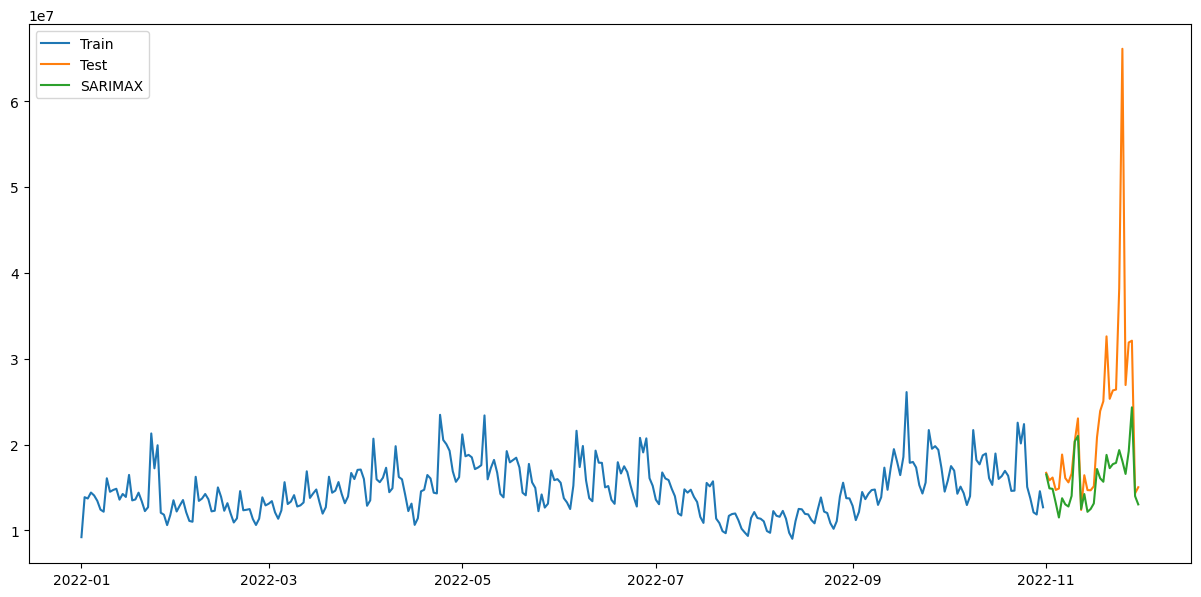

In [14]:
sarimax_pred = model_fit.forecast(steps=periods, exog=exog_test)
evaluate(train_revenue['2022'], test_revenue, sarimax_pred,  'SARIMAX')

## Cross Validation

In [23]:
# Cross validation(Rolling Forecast)
def CV(p, d, q, P, D, Q):
    print('CV For ({}, {}, {}), ({}, {}, {})) started.'.format(p, d, q, P, D, Q))
    n_splits = 10
    test_size = 30
    total_size = len(df)
    start_size = total_size - test_size * n_splits

    errors = []
    for i in range(n_splits):
        print('Split: ', i + 1)
        train = df[:start_size + i * test_size]
        test = df[start_size + i * test_size:start_size + (i + 1) * test_size]
        revenue_train = train['revenue']
        revenue_test = test['revenue']
        exog_train = train[['coupon_rate', 'discount_rate']]
        exog_test = test[['coupon_rate', 'discount_rate']]
        model = SARIMAX(revenue_train, order=(p, d, q), seasonal_order=(P, D, Q, 7), exog=exog_train)
        model_fit = model.fit()
        pred = model_fit.forecast(steps=test_size, exog=exog_test)
        errors.append(root_mean_squared_error(revenue_test, pred))

    
    print(errors)
    print('Mean RMSE: ', np.mean(errors))
    print('Std RMSE: ', np.std(errors))
    return np.mean(errors)

CV(2, 1, 2, 2, 0, 2)



CV For (2, 1, 2), (2, 0, 2)) started.
Split:  1
Split:  2
Split:  3
Split:  4
Split:  5
Split:  6
Split:  7
Split:  8
Split:  9
Split:  10
[1423331.5388777114, 3291445.256197226, 2234012.7897356064, 2244242.6641530367, 2246817.8641084223, 2567584.7344375504, 1071221.469938171, 4783985.349241505, 3180316.54138689, 11033852.367936233]
Mean RMSE:  3407681.057601235
Std RMSE:  2725785.1244056253


np.float64(3407681.057601235)

In [27]:
# Use Cross Validation to find the best model
params = [
    (2, 1, 2, 2, 0, 2),
    (2, 1, 2, 1, 0, 1),
    (1, 1, 2, 2, 0, 2),
    (1, 1, 2, 1, 0, 1),
]


best_rmse = float('inf')
best_params = None
param_rmse = []
for p, d, q, P, D, Q in params:
    rmse = CV(p, d, q, P, D, Q)
    param_rmse.append((p, d, q, P, D, Q, rmse))
    print('RMSE for ({}, {}, {}, {}, {}, {}) is: {}'.format(p, d, q, P, D, Q, rmse))
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = (p, d, q, P, D, Q)

print('Param-RMSE result: ')
for p, d, q, P, D, Q, rmse in param_rmse:
    print('({}, {}, {}, {}, {}, {}) -> {}'.format(p, d, q, P, D, Q, rmse))
    
print('Best Params: ', best_params)
print('Best RMSE: ', best_rmse)

CV For (2, 1, 2), (2, 0, 2)) started.
Split:  1
Split:  2
Split:  3
Split:  4
Split:  5
Split:  6
Split:  7
Split:  8
Split:  9
Split:  10
[1423331.5388777114, 3291445.256197226, 2234012.7897356064, 2244242.6641530367, 2246817.8641084223, 2567584.7344375504, 1071221.469938171, 4783985.349241505, 3180316.54138689, 11033852.367936233]
Mean RMSE:  3407681.057601235
Std RMSE:  2725785.1244056253
RMSE for (2, 1, 2, 2, 0, 2) is: 3407681.057601235
CV For (2, 1, 2), (1, 0, 1)) started.
Split:  1
Split:  2
Split:  3
Split:  4
Split:  5
Split:  6
Split:  7
Split:  8
Split:  9
Split:  10
[1454946.7432942975, 3284923.23700992, 2232312.3634966826, 2244823.4970182306, 2225213.6223622197, 2557676.7592463833, 1076425.3309006805, 4788424.243605334, 3179973.1514742663, 11034596.221052276]
Mean RMSE:  3407931.516946029
Std RMSE:  2724804.5211236873
RMSE for (2, 1, 2, 1, 0, 1) is: 3407931.516946029
CV For (1, 1, 2), (2, 0, 2)) started.
Split:  1
Split:  2
Split:  3
Split:  4
Split:  5
Split:  6
Split:  7
